# LIME & SHAP for Random Forest Model

In [1]:
!pip install shap
!pip install lime
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=df601f20e9c4f3fadba96c9091c66853c3b9cb8c13d126ba2f2200a5c790036e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.utils import shuffle

from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate
import xgboost

from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

import lime
from lime import lime_tabular
import shap

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree

In [3]:
# Set the path to the CSV containing the dataset to train on.
csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

df

Age         Workclass  fnlwgt   Education  Education-Num  \
0       39         State-gov   77516   Bachelors             13   
1       50  Self-emp-not-inc   83311   Bachelors             13   
2       38           Private  215646     HS-grad              9   
3       53           Private  234721        11th              7   
4       28           Private  338409   Bachelors             13   
...    ...               ...     ...         ...            ...   
32556   27           Private  257302  Assoc-acdm             12   
32557   40           Private  154374     HS-grad              9   
32558   58           Private  151910     HS-grad              9   
32559   22           Private  201490     HS-grad              9   
32560   52      Self-emp-inc  287927     HS-grad              9   

           Marital-Status         Occupation   Relationship   Race     Sex  \
0           Never-married       Adm-clerical  Not-in-family  White    Male   
1      Married-civ-spouse    Exec-managerial        Husband  White    Male   
2                Divorced  Handlers-cleaners  Not-in-family  White    Male   
3      Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4      Married-civ-spouse     Prof-specialty           Wife  Black  Female   
...                   ...                ...            ...    ...     ...   
32556  Married-civ-spouse       Tech-support           Wife  White  Female   
32557  Married-civ-spouse  Machine-op-inspct        Husband  White    Male   
32558             Widowed       Adm-clerical      Unmarried  White  Female   
32559       Never-married       Adm-clerical      Own-child  White    Male   
32560  Married-civ-spouse    Exec-managerial           Wife  White  Female   

       Capital-Gain  Capital-Loss  Hours-per-week        Country Over-50K  
0              2174             0              40  United-States    <=50K  
1                 0             0              13  United-States    <=50K  
2                 0             0              40  United-States    <=50K  
3                 0             0              40  United-States    <=50K  
4                 0             0              40           Cuba    <=50K  
...             ...           ...             ...            ...      ...  
32556             0             0              38  United-States    <=50K  
32557             0             0              40  United-States     >50K  
32558             0             0              40  United-States    <=50K  
32559             0             0              20  United-States    <=50K  
32560         15024             0              40  United-States     >50K  

[32561 rows x 15 columns]

In [4]:
country_col_index = df.columns.get_loc("Country")
# Create new column in place of Country
df.insert(loc=country_col_index, column='in_USA', value=df.apply(lambda x: int(x["Country"] == 'United-States'), axis=1))
df.drop('Country', axis=1, inplace=True)
df.head()

Age         Workclass  fnlwgt  Education  Education-Num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       Marital-Status         Occupation   Relationship   Race     Sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   Capital-Gain  Capital-Loss  Hours-per-week  in_USA Over-50K  
0          2174             0              40       1    <=50K  
1             0             0              13       1    <=50K  
2             0             0              40       1    <=50K  
3             0             0              40       1    <=50K  
4             0             0              40       0    <=50K

In [5]:
num_distinct_race_values = df["Race"].nunique()
print("Number of distinct values in the 'Race' column:", num_distinct_race_values)

Number of distinct values in the 'Race' column: 5


In [6]:
race_value_counts = df["Race"].value_counts()
print(race_value_counts)

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: Race, dtype: int64


In [7]:
# Create binary encoding for column Race: White, Black, Other
race_col_index = df.columns.get_loc("Race")

# Step 2: Create the three new binary columns
df['is_White'] = (df['Race'] == 'White').astype(int)
df['is_Black'] = (df['Race'] == 'Black').astype(int)
df['is_Other_Race'] = df['Race'].isin(['Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']).astype(int)

# Step 3: Insert the new columns into the DataFrame at the position of the 'Race' column
# Insert 'is_White'
df.insert(loc=race_col_index, column='is_White', value=df.pop('is_White'))
# Insert 'is_Black'
df.insert(loc=race_col_index + 1, column='is_Black', value=df.pop('is_Black'))
# Insert 'is_Other_Race'
df.insert(loc=race_col_index + 2, column='is_Other_Race', value=df.pop('is_Other_Race'))

# Step 4: Drop the 'Race' column
df.drop('Race', axis=1, inplace=True)

# Display the first few rows to verify changes
df.head()

Age         Workclass  fnlwgt  Education  Education-Num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       Marital-Status         Occupation   Relationship  is_White  is_Black  \
0       Never-married       Adm-clerical  Not-in-family         1         0   
1  Married-civ-spouse    Exec-managerial        Husband         1         0   
2            Divorced  Handlers-cleaners  Not-in-family         1         0   
3  Married-civ-spouse  Handlers-cleaners        Husband         0         1   
4  Married-civ-spouse     Prof-specialty           Wife         0         1   

   is_Other_Race     Sex  Capital-Gain  Capital-Loss  Hours-per-week  in_USA  \
0              0    Male          2174             0              40       1   
1              0    Male             0             0              13       1   
2              0    Male             0             0              40       1   
3              0    Male             0             0              40       1   
4              0  Female             0             0              40       0   

  Over-50K  
0    <=50K  
1    <=50K  
2    <=50K  
3    <=50K  
4    <=50K

In [8]:
categorical_features = ["Workclass", "Education", "Marital-Status", "Occupation", "Relationship", "Sex"] #, "Race", "Country"
category_mappings = {}
for feature in categorical_features:
    label_encoder = LabelEncoder()
    df[feature] = label_encoder.fit_transform(df[feature])
    category_mappings[feature] = {label: index for index, label in enumerate(label_encoder.classes_)}
df['Over-50K'] = df['Over-50K'].map({'<=50K': 0, '>50K': 1})

df.head()

Age  Workclass  fnlwgt  Education  Education-Num  Marital-Status  \
0   39          7   77516          9             13               4   
1   50          6   83311          9             13               2   
2   38          4  215646         11              9               0   
3   53          4  234721          1              7               2   
4   28          4  338409          9             13               2   

   Occupation  Relationship  is_White  is_Black  is_Other_Race  Sex  \
0           1             1         1         0              0    1   
1           4             0         1         0              0    1   
2           6             1         1         0              0    1   
3           6             0         0         1              0    1   
4          10             5         0         1              0    0   

   Capital-Gain  Capital-Loss  Hours-per-week  in_USA  Over-50K  
0          2174             0              40       1         0  
1             0             0              13       1         0  
2             0             0              40       1         0  
3             0             0              40       1         0  
4             0             0              40       0         0

In [9]:
columns_to_drop = ['fnlwgt', 'Education', 'Over-50K']

X_dropped = df.drop(columns_to_drop, axis=1)
y = df['Over-50K']
X_train_dropped, X_test_dropped, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state=57)

clf_dropped = RandomForestClassifier(n_estimators=1000, max_depth=8, random_state=57)
clf_dropped.fit(X_train_dropped, y_train)

y_pred_dropped = clf_dropped.predict(X_test_dropped)

print(f"Accuracy: {accuracy_score(y_test, y_pred_dropped)}")
print(classification_report(y_test, y_pred_dropped))

Accuracy: 0.855980346998311
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4952
           1       0.80      0.53      0.64      1561

    accuracy                           0.86      6513
   macro avg       0.84      0.74      0.77      6513
weighted avg       0.85      0.86      0.84      6513



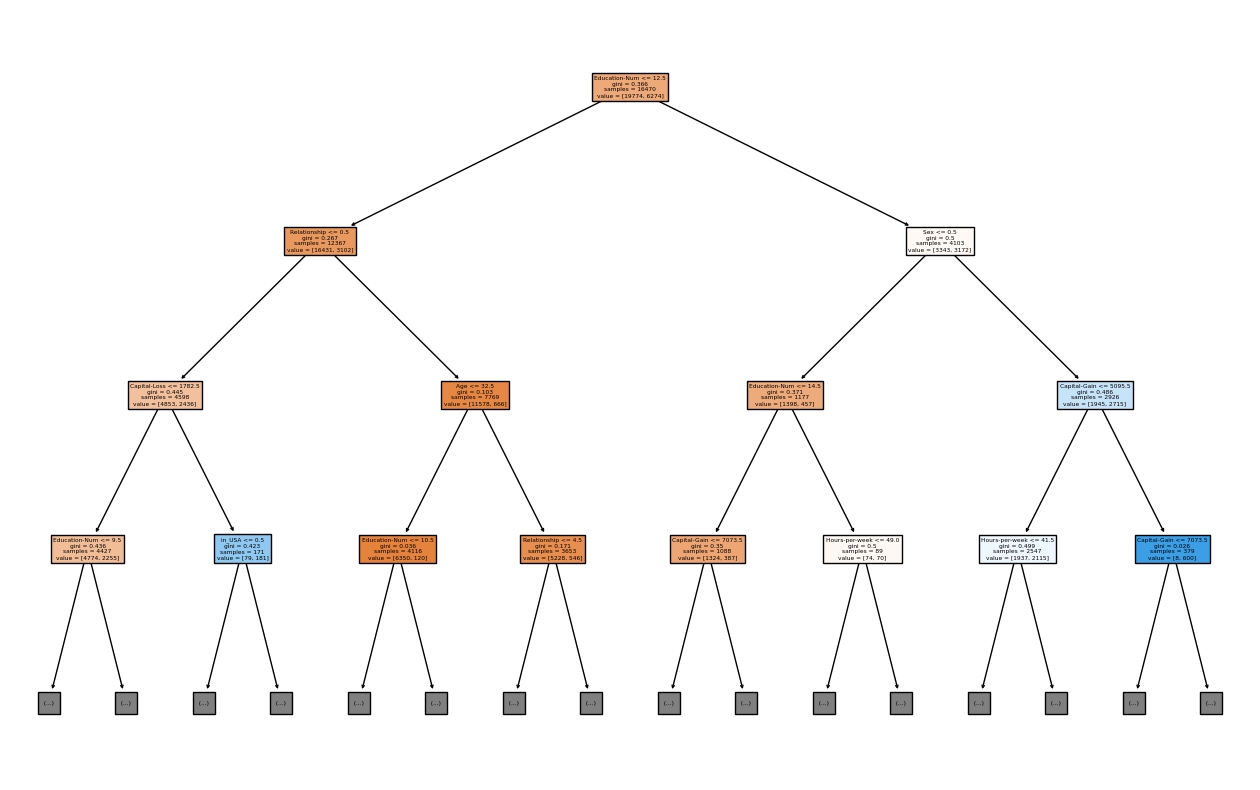

In [10]:
single_tree = clf_dropped.estimators_[0]

plt.figure(figsize=(16,10))
plot_tree(single_tree, feature_names=X_train_dropped.columns, filled=True, max_depth=3)
plt.show()

## Lime for Random Forest

In [11]:
# generate explainer object that can be used for explaining individual predictions
class_names = ['<=50K', '>50K']
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train_dropped),feature_names=X_train_dropped.columns,class_names=class_names,
    mode='classification')

In [12]:
test_index = 1
instance = X_test_dropped.iloc[test_index]
print('Model prediction: ', class_names[y_pred_dropped[test_index]])
print(instance)

Model prediction:  <=50K
Age               46
Workclass          4
Education-Num     10
Marital-Status     2
Occupation         1
Relationship       0
is_White           1
is_Black           0
is_Other_Race      0
Sex                1
Capital-Gain       0
Capital-Loss       0
Hours-per-week    40
in_USA             1
Name: 31126, dtype: int64


In [13]:
y_test_df_rf = pd.DataFrame(y_test, columns=["Over-50K"])
y_test_df_rf

Over-50K
20934         0
31126         1
7177          1
18854         0
10919         1
...         ...
12758         1
11903         0
11661         0
19389         0
4225          0

[6513 rows x 1 columns]

In [14]:
exp = explainer.explain_instance(
    data_row=X_test_dropped.iloc[test_index],
    predict_fn=clf_dropped.predict_proba #(test_dataframe[optimized_features])[:, 1]
)

print('Model prediction: ', class_names[y_pred_dropped[test_index]])
print('True label: ', class_names[y_test_df_rf.iloc[test_index].values[0]])
# check also LIME linear model predictions
top_labels = exp.available_labels()
print('LIME prediction: ', class_names[y_pred_dropped[test_index]])

exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model prediction:  <=50K
True label:  >50K
LIME prediction:  <=50K


In [15]:
test_index = 4
exp = explainer.explain_instance(
    data_row=X_test_dropped.iloc[test_index],
    predict_fn=clf_dropped.predict_proba #(test_dataframe[optimized_features])[:, 1]
)

print('Model prediction: ', class_names[y_pred_dropped[test_index]])
print('True label: ', class_names[y_test_df_rf.iloc[test_index].values[0]])
# check also LIME linear model predictions
top_labels = exp.available_labels()
print('LIME prediction: ', class_names[y_pred_dropped[test_index]])

exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model prediction:  >50K
True label:  >50K
LIME prediction:  >50K


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

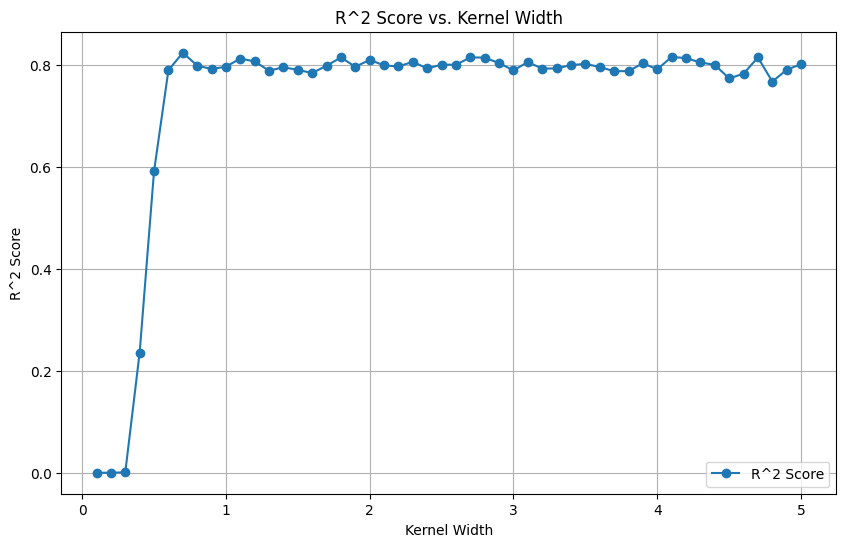

In [16]:
# Your setup variables
class_names = ['<=50K', '>50K']
kernel_widths = np.linspace(0.1, 5.0, 50)  # Adjust this as needed for your experiment
r2_scores = []

for width in kernel_widths:
    # Initialize explainer with the current kernel width
    explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train_dropped),
                                     feature_names=X_train_dropped.columns,
                                     class_names=class_names,
                                     mode='classification',
                                     kernel_width=width)

    # Explain instance without specifying kernel_width here
    exp = explainer.explain_instance(data_row=X_test_dropped.iloc[test_index],
                                     predict_fn=clf_dropped.predict_proba)

    # Record R^2 score
    r2_scores.append(exp.score)

# Plotting R^2 scores against kernel widths
plt.figure(figsize=(10, 6))
plt.plot(kernel_widths, r2_scores, '-o', label='R^2 Score')
plt.title('R^2 Score vs. Kernel Width')
plt.xlabel('Kernel Width')
plt.ylabel('R^2 Score')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Specified kernel widths
kernel_widths = [0.3, 1.8, 4.2]

for width in kernel_widths:
    # Initialize a new explainer for each kernel width
    explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train_dropped),
                                     feature_names=X_train_dropped.columns,
                                     class_names=class_names,
                                     mode='classification',
                                     kernel_width=width)

    # Generate explanation for the specified instance
    exp = explainer.explain_instance(data_row=X_test_dropped.iloc[test_index],
                                     predict_fn=clf_dropped.predict_proba)

    print(f'Kernel Width: {width}')
    print('Model prediction: ', class_names[y_pred_dropped[test_index]])
    print('True label: ', class_names[y_test_df_rf.iloc[test_index].values[0]])
    top_labels = exp.available_labels()
    print('LIME prediction (top label):', class_names[top_labels[0]] if top_labels else 'N/A')

    # Displaying the explanation
    # Note: This function call is ideally suited for Jupyter Notebook environments.
    exp.show_in_notebook(show_table=True)
    print("\n\n")

Output hidden; open in https://colab.research.google.com to view.

## SHAP for RandomForest

In [18]:
shap.initjs()

# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer_rf = shap.TreeExplainer(clf_dropped)
shap_values = explainer_rf.shap_values(X_test_dropped)

In [20]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[0], shap_values[0][:, 0], X_test_dropped.iloc[0, :])

In [21]:
explainer_rf.expected_value.shape

(2,)

In [22]:
shap.initjs()
shap.force_plot(
    explainer_rf.expected_value[0], shap_values[:100, :, 0], X_test_dropped.iloc[:100, :]
)

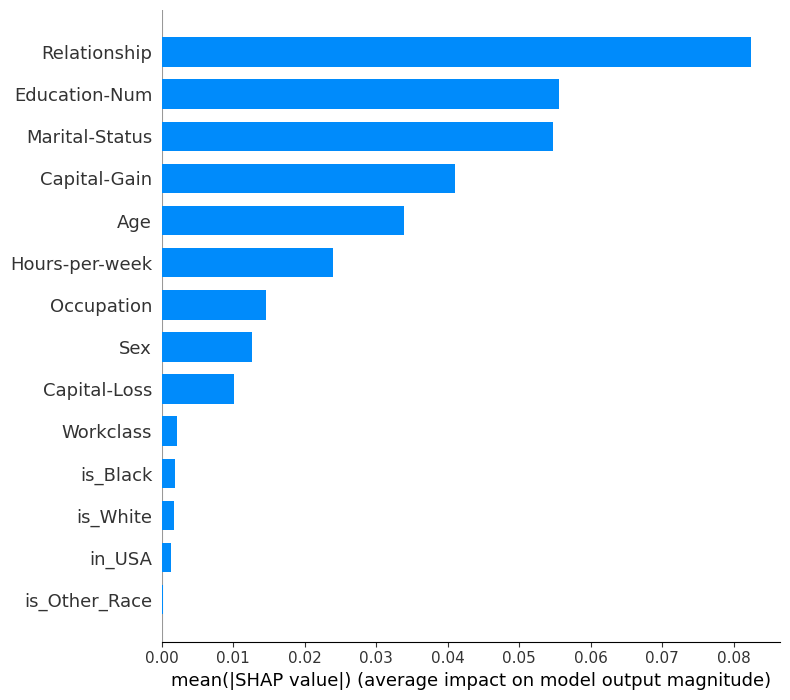

In [23]:
# Takes the average of the SHAP value magnitudes across the dataset
shap.summary_plot(shap_values[:100, :, 0], X_test_dropped.iloc[:100, :], plot_type="bar")

## SHAP Summary Plot RF
Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

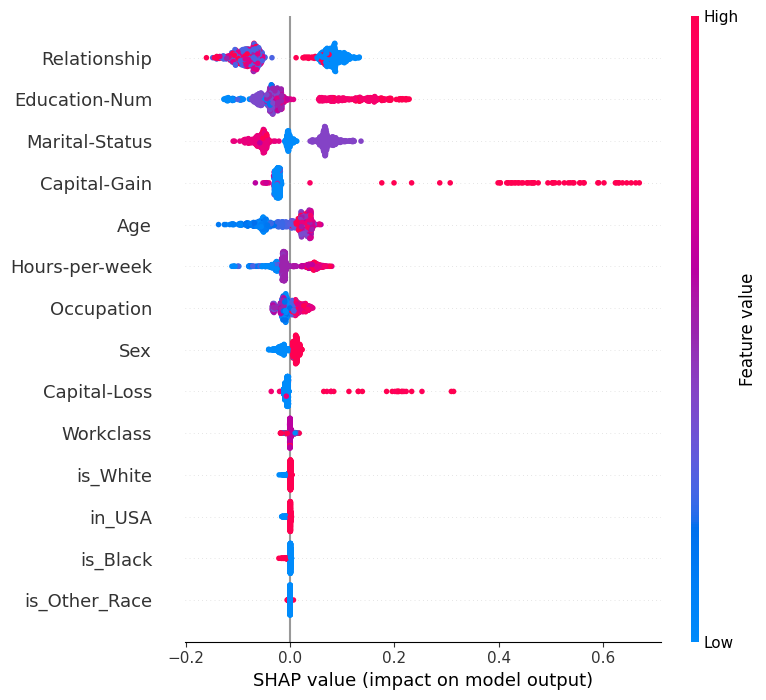

In [25]:
shap.summary_plot(shap_values[:1000, :, 1], X_test_dropped.iloc[:1000, :])

## SHAP Dependence Plots RF
SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

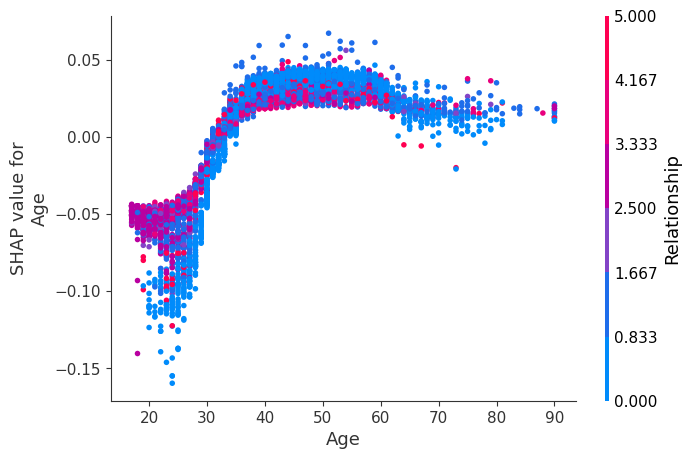

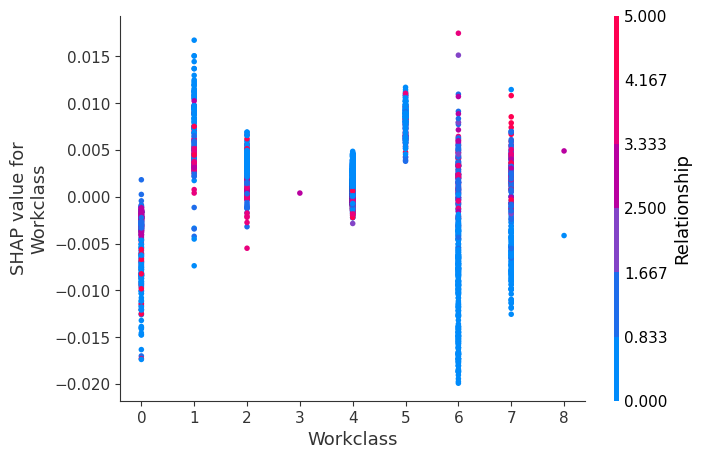

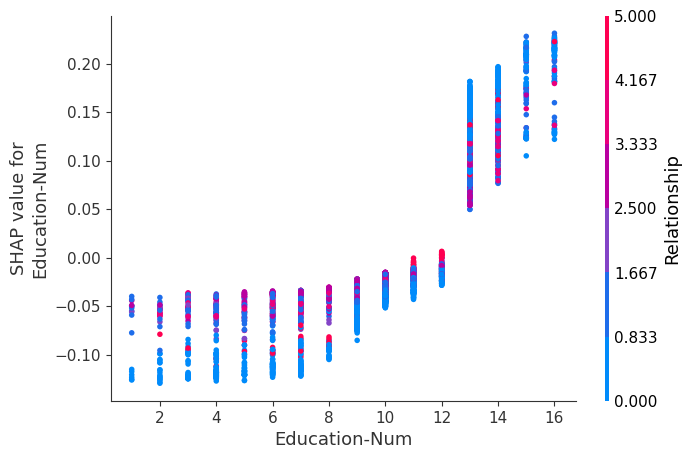

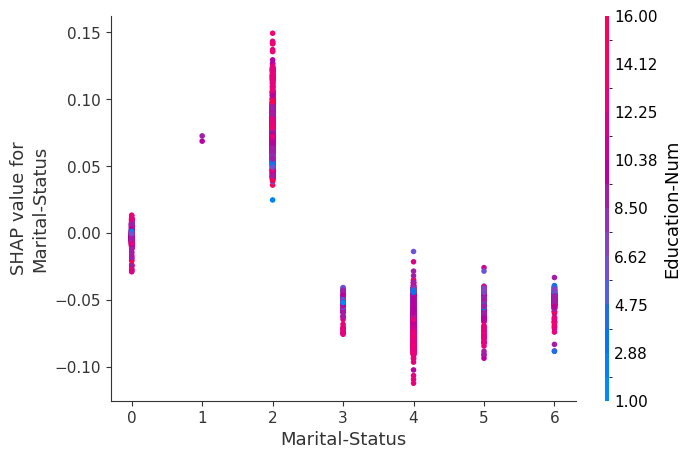

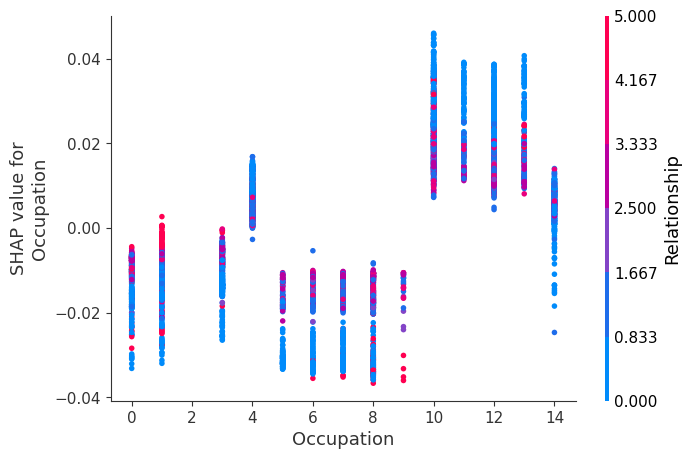

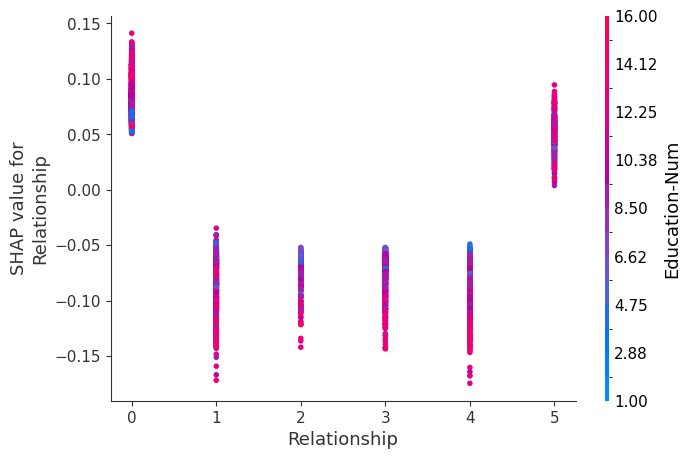

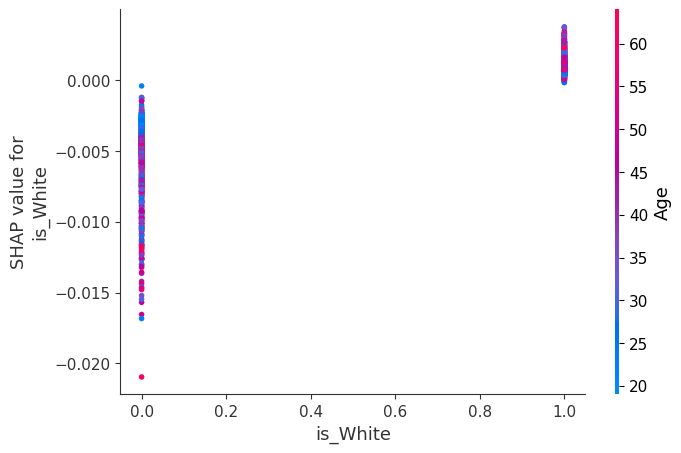

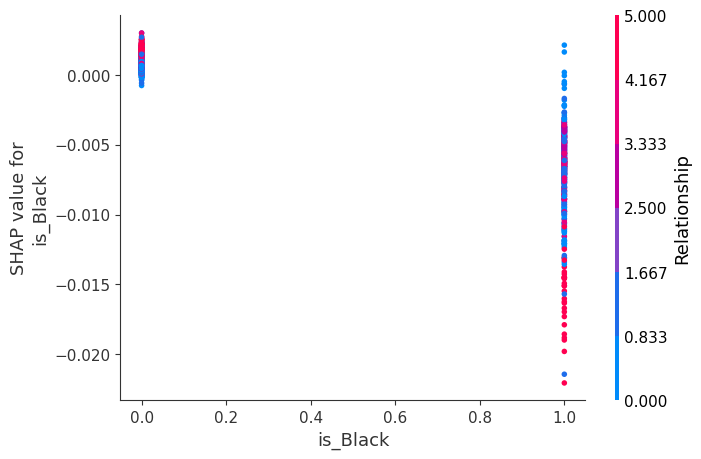

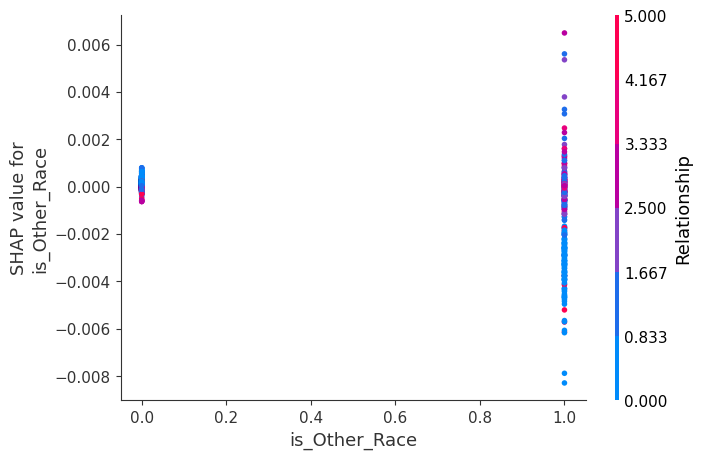

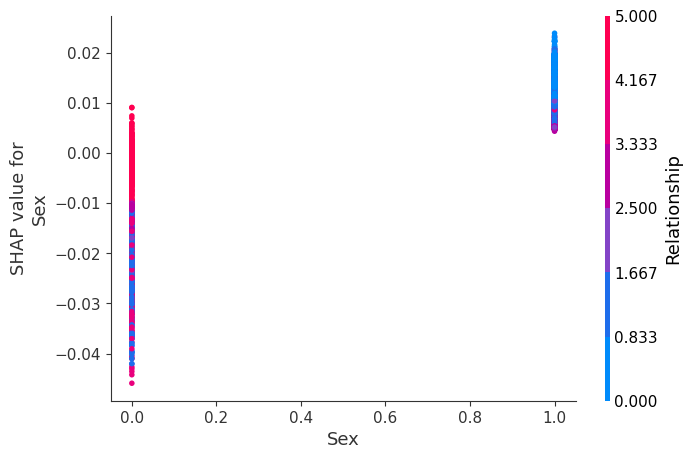

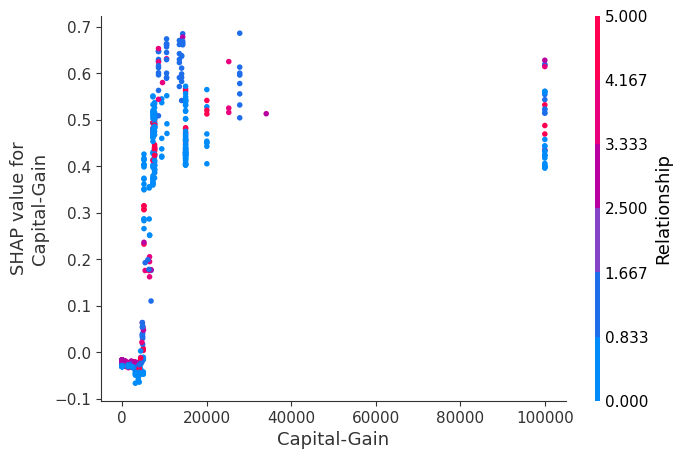

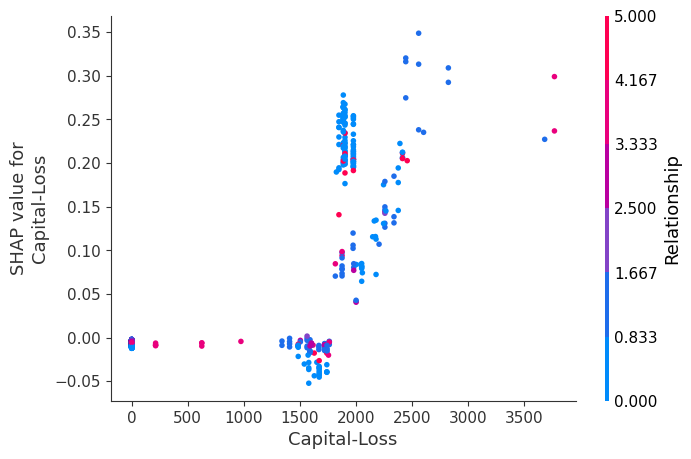

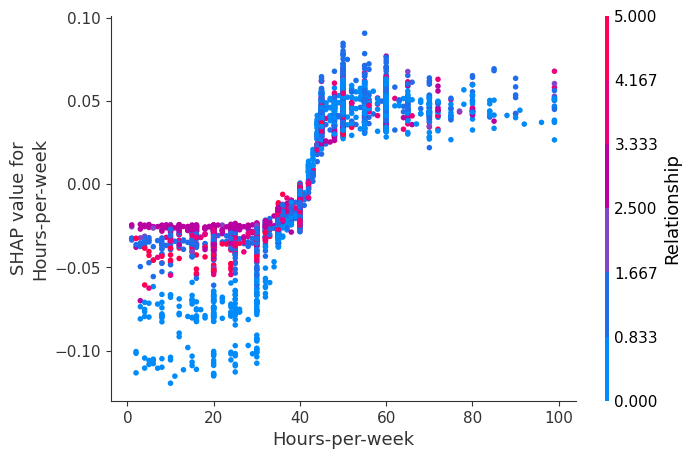

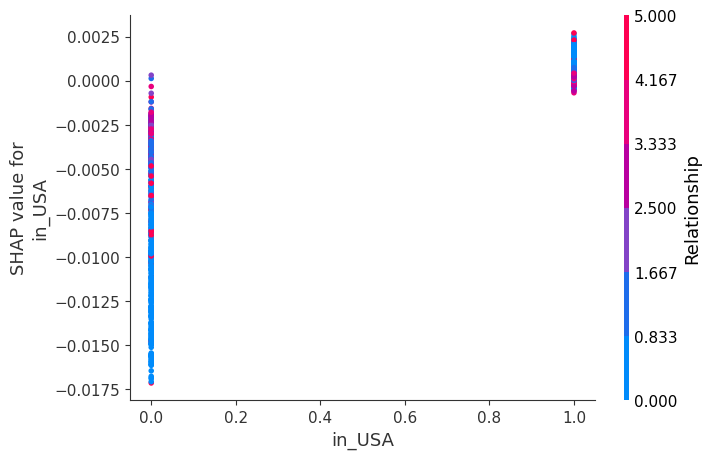

In [26]:
for name in X_train_dropped.columns:
    shap.dependence_plot(name, shap_values[:, :, 1], X_test_dropped, display_features=X_test_dropped)

## SHAP after upsampling using SMOTE

In [29]:
# Upsampling using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_dropped, y)

In [30]:
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

In [31]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_dropped, y, test_size=0.2)

In [32]:
clf_resampled = RandomForestClassifier(n_estimators=1000, max_depth=8, random_state=57)
clf_resampled.fit(X_train_resampled, y_train_resampled)

y_pred_resampled = clf_resampled.predict(X_test_resampled)

print(f"Accuracy: {accuracy_score(y_test_resampled, y_pred_resampled)}")
print(classification_report(y_test_resampled, y_pred_resampled))

Accuracy: 0.8529095654844158
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      4908
           1       0.83      0.50      0.63      1605

    accuracy                           0.85      6513
   macro avg       0.84      0.74      0.77      6513
weighted avg       0.85      0.85      0.84      6513



In [33]:
shap.initjs()

# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer_rf = shap.TreeExplainer(clf_resampled)
shap_values = explainer_rf.shap_values(X_test_resampled)

In [34]:
print(shap_values.shape)
print(X_resampled.shape)

(6513, 14, 2)
(49440, 14)


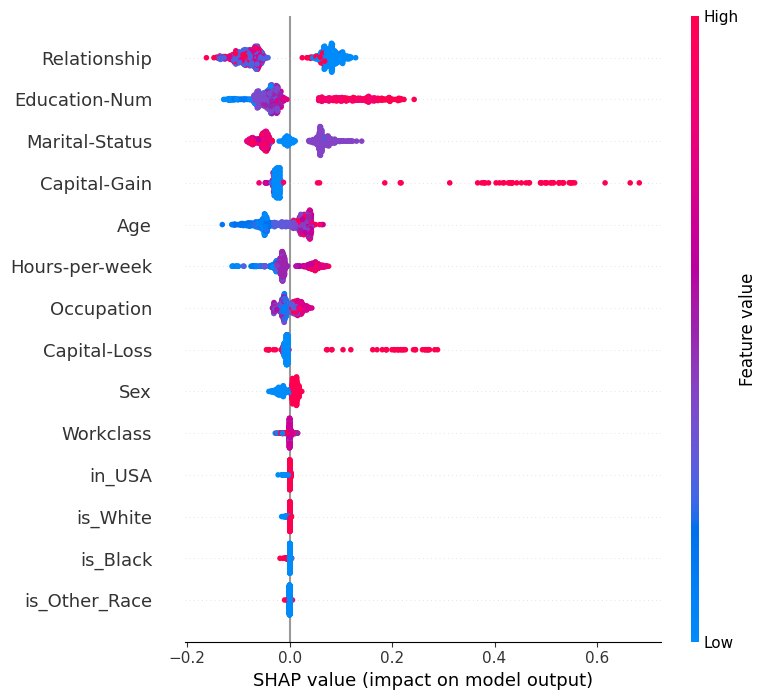

In [35]:
shap.summary_plot(shap_values[:1000, :, 1], X_test_resampled.iloc[:1000, :])

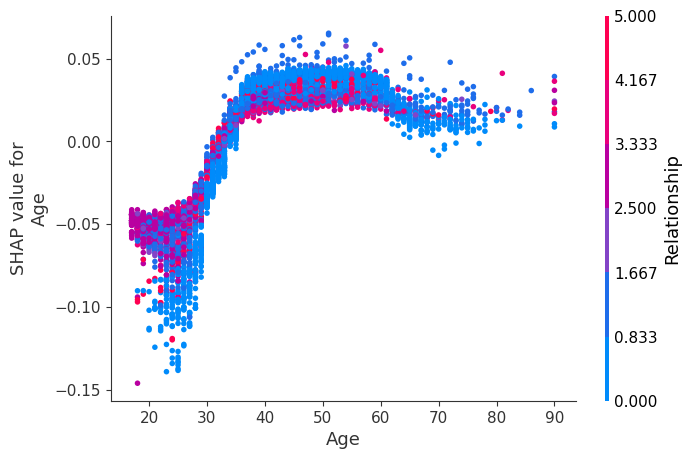

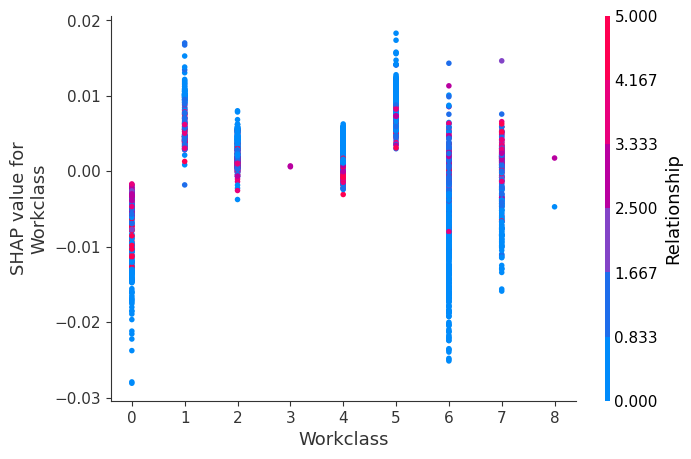

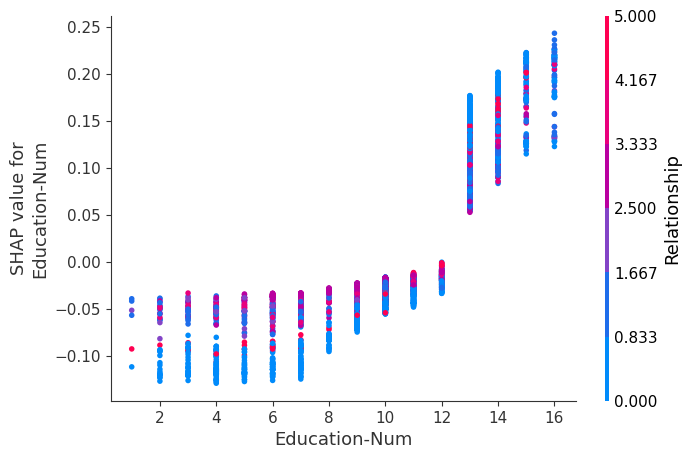

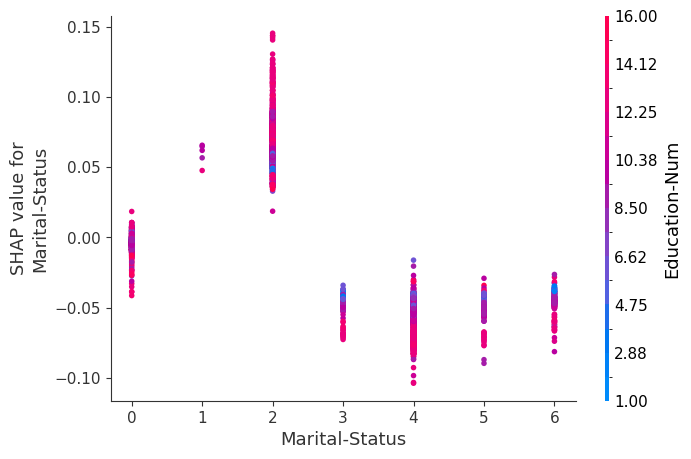

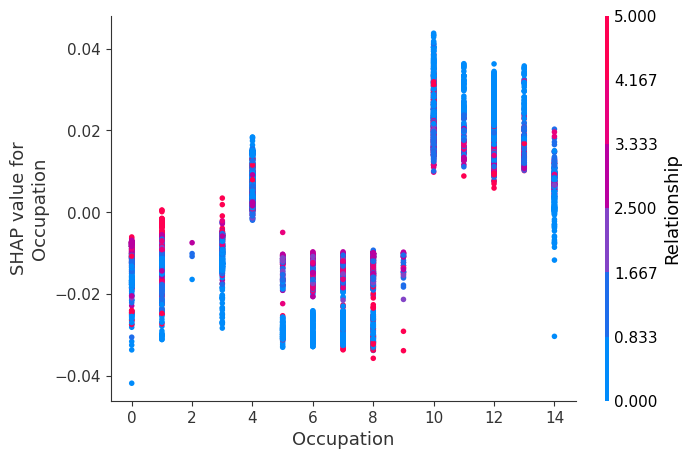

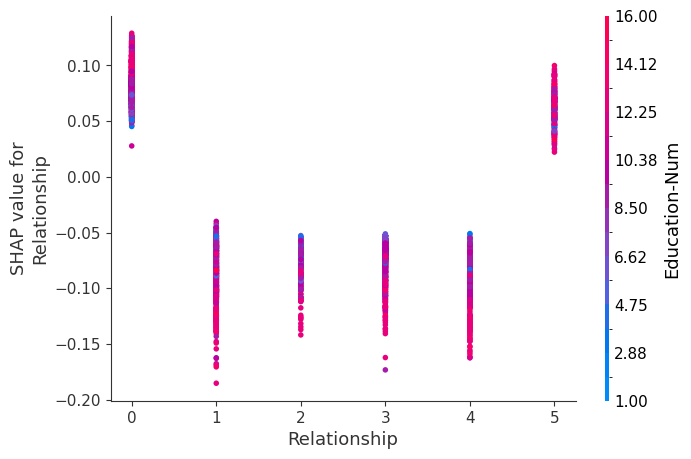

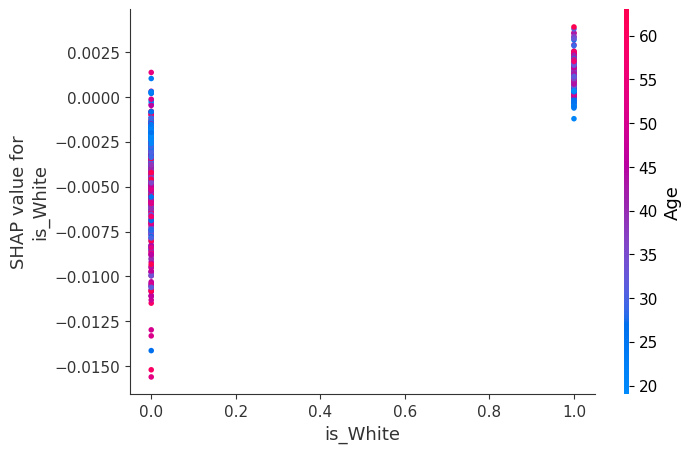

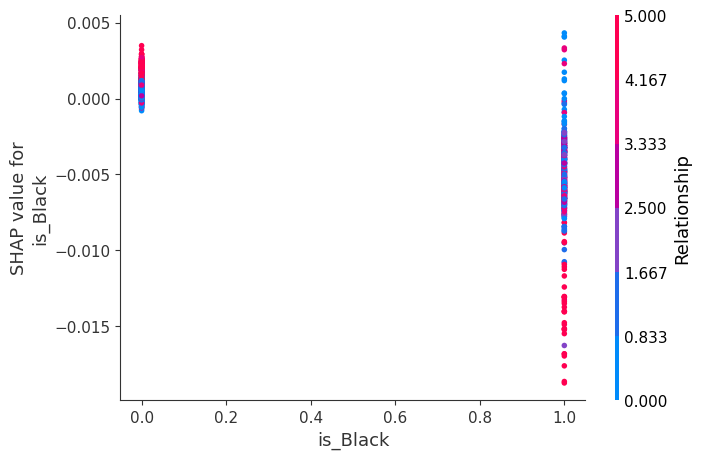

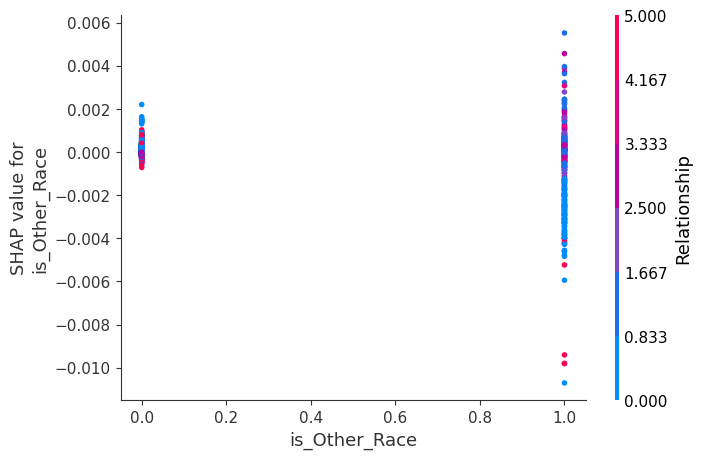

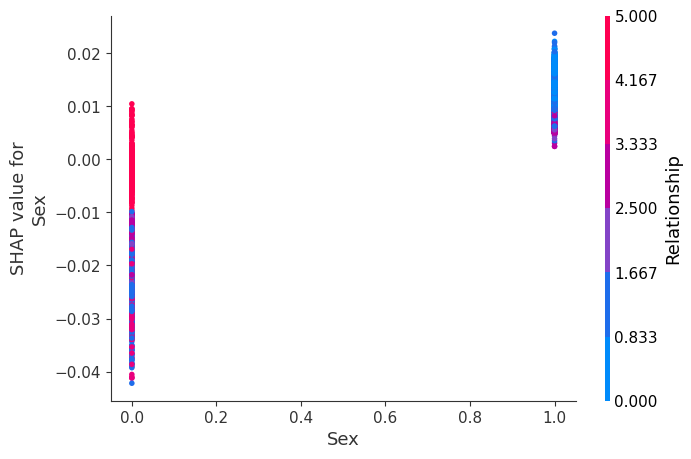

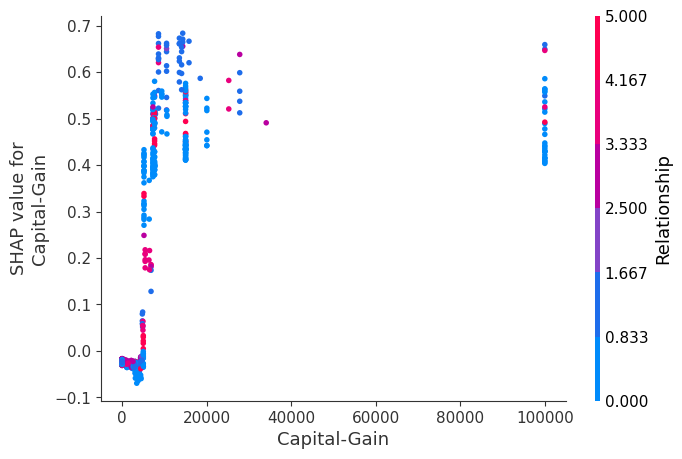

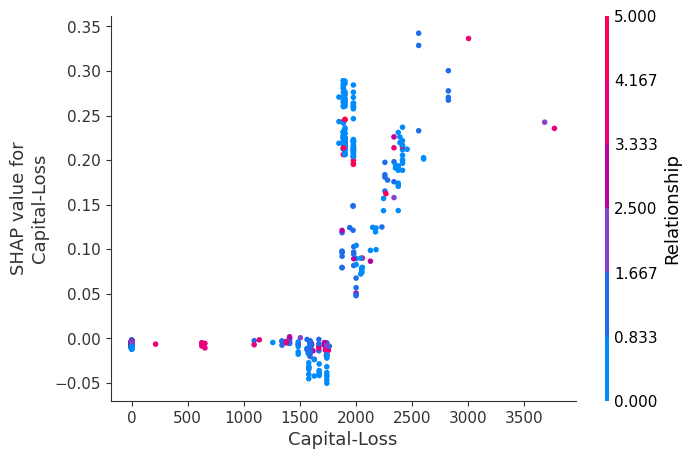

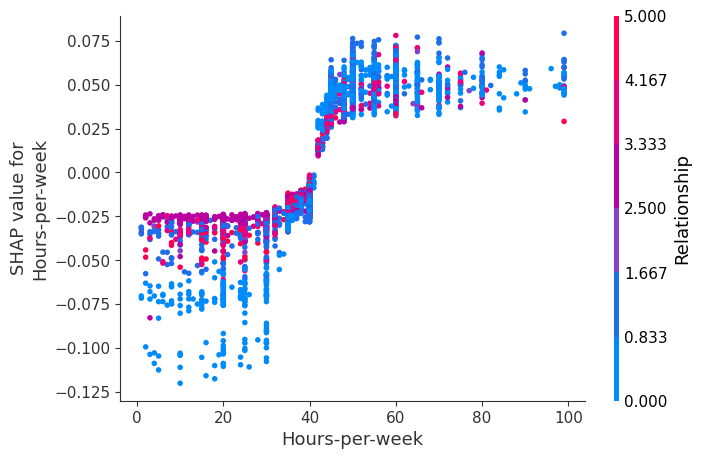

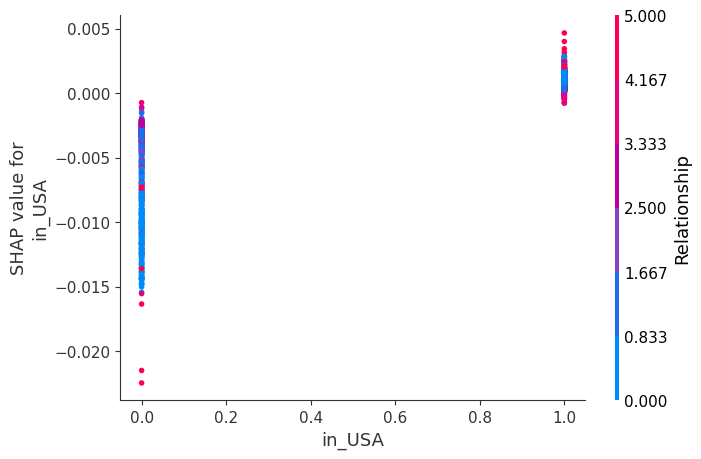

In [36]:
for name in X_train_resampled.columns:
    shap.dependence_plot(name, shap_values[:, :, 1], X_test_resampled, display_features=X_test_resampled)

## Causal explanations using PyXAI

In [61]:
!pip install pyxai
from pyxai import Tools, Builder, Explainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 87.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 52.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [62]:
X_test_sample = X_test_dropped.sample(n=1000)

In [63]:
clf_dropped2 = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=57)
clf_dropped2.fit(X_train_dropped, y_train)

y_pred_dropped2 = clf_dropped2.predict(X_test_dropped)

print(f"Accuracy: {accuracy_score(y_test, y_pred_dropped)}")
print(classification_report(y_test, y_pred_dropped))

Accuracy: 0.855980346998311
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4952
           1       0.80      0.53      0.64      1561

    accuracy                           0.86      6513
   macro avg       0.84      0.74      0.77      6513
weighted avg       0.85      0.86      0.84      6513



In [64]:
# import model for pyxai
from pyxai import Learning
learner, model = Learning.import_models(clf_dropped2, X_test_sample.columns)

---------------   Explainer   ----------------
For the evaluation number 0:
**Random Forest Model**
nClasses: 2
nTrees: 10
nVariables: 198



In [65]:
df_small_sample = df.iloc[:1000]
df_small_sample

Age  Workclass  fnlwgt  Education  Education-Num  Marital-Status  \
0     39          7   77516          9             13               4   
1     50          6   83311          9             13               2   
2     38          4  215646         11              9               0   
3     53          4  234721          1              7               2   
4     28          4  338409          9             13               2   
..   ...        ...     ...        ...            ...             ...   
995   56          4  112840         11              9               2   
996   45          4   89325         12             14               0   
997   48          1   33109          9             13               0   
998   40          4   82465         15             10               2   
999   39          5  329980          9             13               2   

     Occupation  Relationship  is_White  is_Black  is_Other_Race  Sex  \
0             1             1         1         0              0    1   
1             4             0         1         0              0    1   
2             6             1         1         0              0    1   
3             6             0         0         1              0    1   
4            10             5         0         1              0    0   
..          ...           ...       ...       ...            ...  ...   
995           4             0         1         0              0    1   
996          10             1         1         0              0    1   
997           4             4         1         0              0    1   
998           7             0         1         0              0    1   
999           4             0         1         0              0    1   

     Capital-Gain  Capital-Loss  Hours-per-week  in_USA  Over-50K  
0            2174             0              40       1         0  
1               0             0              13       1         0  
2               0             0              40       1         0  
3               0             0              40       1         0  
4               0             0              40       0         0  
..            ...           ...             ...     ...       ...  
995             0             0              55       1         1  
996             0             0              45       1         0  
997             0             0              58       1         1  
998          2580             0              40       1         0  
999         15024             0              50       1         1  

[1000 rows x 17 columns]

In [72]:
instance, prediction = learner.get_instances(dataset=df_small_sample, model=model, n=1)
print("instance:", instance)
print("prediction:", prediction)

---------------   Instances   ----------------
number of instances selected: 1
----------------------------------------------
instance: [   39     7 77516     9    13     4     1     1     1     0     0     1
  2174     0    40     1]
prediction: 0


In [73]:
explainer = Explainer.initialize(model, instance=instance)

direct_reason = explainer.direct_reason()
print("len direct reason:", len(direct_reason))

len direct reason: 30


In [74]:
print("len binary representation:", len(explainer.binary_representation))
print("len direct:", len(direct_reason))
print("is_reason:", explainer.is_reason(direct_reason))
print("to_features:", explainer.to_features(direct_reason, contrastive=True))

len binary representation: 198
len direct: 30
is_reason: True
to_features: ('Age > 30.5', 'Workclass > 1.5', 'Education-Num > 12.5', 'Marital-Status > 2.5', 'Occupation > 7.0', 'Relationship in ]0.5, 4.5]', 'is_Black > 0.5', 'Sex <= 0.5', 'Capital-Gain <= 7139.5', 'Capital-Loss <= 3011.0', 'Hours-per-week > 41.5')


In [75]:
sufficient = explainer.sufficient_reason()
print("len sufficient reason:", len(sufficient))

print("to_features:", explainer.to_features(sufficient, contrastive=True))

len sufficient reason: 15
to_features: ('Age > 30.5', 'Workclass > 4.5', 'Education-Num > 12.5', 'Marital-Status > 2.5', 'Relationship in ]0.5, 4.5]', 'Sex <= 0.5', 'Capital-Gain <= 7139.5', 'Capital-Loss <= 2377.0', 'Hours-per-week > 43.5')


In [76]:
majoritary_reason = explainer.majoritary_reason(time_limit=10)
print("majoritary_reason", len(majoritary_reason))
#explainer.visualisation.notebook(instance, majoritary_reason)
print("to_features:", explainer.to_features(majoritary_reason, contrastive=True))

majoritary_reason 16
to_features: ('Workclass > 4.5', 'Marital-Status > 2.5', 'Occupation > 9.5', 'Relationship in ]0.5, 4.5]', 'is_Black > 0.5', 'Sex <= 0.5', 'Capital-Gain <= 7731.5', 'Capital-Loss <= 3011.0', 'Hours-per-week > 44.5')


In [77]:
contrastive_reason = explainer.minimal_contrastive_reason(n=1, time_limit=10)
if explainer.elapsed_time == Explainer.TIMEOUT:
    print('this is an approximation')
if len(contrastive_reason) > 0:
    print("constrative: ", explainer.to_features(contrastive_reason, contrastive=True))
else:
    print('No contrative reason found')

constrative:  ('Marital-Status > 2.5', 'Relationship > 0.5')
